<a href="https://colab.research.google.com/github/fahriyegrl/Malicious_Web__Detection__with__1D_CNN_and_RNN/blob/main/Malicious_Web__Detection__with__1D_CNN_and_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import re
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
import seaborn as sns
import gc
import random
import os
import pickle
import tensorflow as tf
from tensorflow.python.util import deprecation
from urllib.parse import urlparse


from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models, layers, backend, metrics
from tensorflow.keras.callbacks import EarlyStopping
# Change the import statement to the correct location
from tensorflow.keras.utils import plot_model
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
!pip install tldextract -q

In [ ]:
import tldextract

In [ ]:
data = pd.read_csv('malicious_phish.csv')
data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [ ]:
val_size = 0.2
train_data, val_data = train_test_split(data, test_size=val_size, stratify=data['type'], random_state=42)
fig = go.Figure([go.Pie(labels=['Train Size', 'Validation Size'], values=[train_data.shape[0], val_data.shape[0]])])
fig.update_layout(title='Train and Validation Size')
fig.show()

In [ ]:
fig = go.Figure([go.Pie(labels=['benign', 'defacement', 'malware', 'phishing'], values=data.type.value_counts())])
fig.update_layout(title='Percentage of Class (Benign, Defacement, Malware and Phishing)')
fig.show()

In [ ]:
def parsed_url(url):
    # extract subdomain, domain, and domain suffix from url
    # if item == '', fill with '<empty>'
    extracted = tldextract.extract(url) # Get the ExtractResult object
    subdomain = '<empty>' if extracted.subdomain == '' else extracted.subdomain # Access subdomain attribute
    domain = '<empty>' if extracted.domain == '' else extracted.domain # Access domain attribute
    domain_suffix = '<empty>' if extracted.suffix == '' else extracted.suffix # Access suffix attribute

    return [subdomain, domain, domain_suffix]

def extract_url(data):
    # parsed url
    extract_url_data = [parsed_url(url) for url in data['url']]
    extract_url_data = pd.DataFrame(extract_url_data, columns=['subdomain', 'domain', 'domain_suffix'])

    # concat extracted feature with main data
    data = data.reset_index(drop=True)
    data = pd.concat([data, extract_url_data], axis=1)

    return data

def get_frequent_group(data, n_group):
    # get the most frequent
    data = data.value_counts().reset_index(name='values')

    # scale log base 10
    data['values'] = np.log10(data['values'])

    # calculate total values
    # x_column (subdomain / domain / domain_suffix)
    x_column = data.columns[1]
    data['total_values'] = data[x_column].map(data.groupby(x_column)['values'].sum().to_dict())

    # get n_group data order by highest values
    data_group = data.sort_values('total_values', ascending=False).iloc[:, 1].unique()[:n_group]
    data = data[data.iloc[:, 1].isin(data_group)]
    data = data.sort_values('total_values', ascending=False)

    return data

def plot(data, n_group, title):
    data = get_frequent_group(data, n_group)
    fig = px.bar(data, x=data.columns[1], y='values', color='label')
    fig.update_layout(title=title)
    fig.show()


In [ ]:
data = extract_url(data)
train_data = extract_url(train_data)
val_data = extract_url(val_data)

In [ ]:
fig = go.Figure([go.Bar(
    x=['domain', 'Subdomain', 'Domain Suffix'],
    y = [data.domain.nunique(), data.subdomain.nunique(), data.domain_suffix.nunique()]
)])
fig.show()

In [ ]:
data[(data['domain'] == 'google') & (data['type'] == 'phishing')].head()

,url,type,subdomain,domain,domain_suffix
40,https://docs.google.com/spreadsheet/viewform?f...,phishing,docs,google,com
4551,https://spreadsheets.google.com/spreadsheet/fo...,phishing,spreadsheets,google,com
6249,https://spreadsheets.google.com/spreadsheet/em...,phishing,spreadsheets,google,com
18018,https://spreadsheets.google.com/spreadsheet/em...,phishing,spreadsheets,google,com
18116,https://sites.google.com/site/habbomoedasgt/,phishing,sites,google,com


In [ ]:
###   do tokenization on the url so that it can be used as input to the CNN model
tokenizer = Tokenizer(filters='', char_level=True, lower=False, oov_token=1)

# fit only on training data
tokenizer.fit_on_texts(train_data['url'])
n_char = len(tokenizer.word_index.keys())

train_seq = tokenizer.texts_to_sequences(train_data['url'])
val_seq = tokenizer.texts_to_sequences(val_data['url'])

print('Before tokenization: ')
print(train_data.iloc[0]['url'])
print('\nAfter tokenization: ')
print(train_seq[0])

Before tokenization: 
lead411.com/Terence_Thornhill_471432.html

After tokenization: 
[14, 2, 5, 16, 36, 23, 23, 12, 9, 3, 13, 6, 59, 2, 11, 2, 8, 9, 2, 37, 59, 18, 3, 11, 8, 18, 7, 14, 14, 37, 36, 38, 23, 36, 30, 25, 12, 18, 4, 13, 14]


In [ ]:
### Each url has a different length, therefore padding is needed to equalize each url length

sequence_length = np.array([len(i) for i in train_seq])
sequence_length = np.percentile(sequence_length, 99).astype(int)
print(f'Before padding: \n {train_seq[0]}')
train_seq = pad_sequences(train_seq, padding='post', maxlen=sequence_length)
val_seq = pad_sequences(val_seq, padding='post', maxlen=sequence_length)
print(f'After padding: \n {train_seq[0]}')

Before padding: 
 [14, 2, 5, 16, 36, 23, 23, 12, 9, 3, 13, 6, 59, 2, 11, 2, 8, 9, 2, 37, 59, 18, 3, 11, 8, 18, 7, 14, 14, 37, 36, 38, 23, 36, 30, 25, 12, 18, 4, 13, 14]
After padding: 
 [14  2  5 16 36 23 23 12  9  3 13  6 59  2 11  2  8  9  2 37 59 18  3 11
  8 18  7 14 14 37 36 38 23 36 30 25 12 18  4 13 14  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


In [ ]:
###  encode subdomain, domain, suffix domains and label into numerical variables

unique_value = {}
for feature in ['subdomain', 'domain', 'domain_suffix']:
    # get unique value
    label_index = {label: index for index, label in enumerate(train_data[feature].unique())}

    # add unknown label in last index
    label_index['<unknown>'] = list(label_index.values())[-1] + 1

    # count unique value
    unique_value[feature] = label_index['<unknown>']

    # encode
    train_data.loc[:, feature] = [label_index[val] if val in label_index else label_index['<unknown>'] for val in train_data.loc[:, feature]]
    val_data.loc[:, feature] = [label_index[val] if val in label_index else label_index['<unknown>'] for val in val_data.loc[:, feature]]

train_data.head()

,url,type,subdomain,domain,domain_suffix
0,lead411.com/Terence_Thornhill_471432.html,benign,0,0,0
1,http://aciai.com.br/index.php?option=com_conte...,defacement,0,1,1
2,hotflick.net/celebs/kelly_kruger.html,benign,0,2,2
3,antonyme-dictionnaire-improvement.effers.com,phishing,1,3,0
4,abebooks.com/book-search/kw/kazimierz-malinowski/,benign,0,4,0


In [ ]:
### encode the target variable (label) to numeric
### 'benign', 'defacement', 'malware', 'phishing'


for data in [train_data, val_data]:
    data.loc[:, 'type'] = [0 if i == 'benign' else 1 if i=='defacement' else 2 if i=='malware' else 3 for i in data.loc[:, 'type']]

train_data.head()


,url,type,subdomain,domain,domain_suffix
0,lead411.com/Terence_Thornhill_471432.html,0,0,0,0
1,http://aciai.com.br/index.php?option=com_conte...,1,0,1,1
2,hotflick.net/celebs/kelly_kruger.html,0,0,2,2
3,antonyme-dictionnaire-improvement.effers.com,3,1,3,0
4,abebooks.com/book-search/kw/kazimierz-malinowski/,0,0,4,0


In [ ]:
### Create CNN Model
def convolution_block(x):
    conv_3_layer = layers.Conv1D(64, 3, padding='same', activation='elu')(x)

    conv_5_layer = layers.Conv1D(64, 5, padding='same', activation='elu')(x)
    conv_layer = layers.concatenate([x, conv_3_layer, conv_5_layer])
    conv_layer = layers.Flatten()(conv_layer)

    return conv_layer

def embedding_block(unique_value, size, name):
    input_layer = layers.Input(shape=(1,), name=name + '_input')
    embedding_layer = layers.Embedding(unique_value, size, input_length=1)(input_layer)

    return input_layer, embedding_layer

def create_model(sequence_length, n_char, unique_value):
    input_layer = []

    # sequence input layer
    sequence_input_layer = layers.Input(shape=(sequence_length,), name='url_input')
    print(sequence_input_layer.shape)
    input_layer.append(sequence_input_layer)

    # convolution block
    char_embedding = layers.Embedding(n_char + 1, 32, input_length=sequence_length)(sequence_input_layer)
    print(char_embedding.shape)
    conv_layer = convolution_block(char_embedding)
    print(conv_layer.shape)

    # entity embedding
    entity_embedding = []
    for key, n in unique_value.items():
        size = 4
        input_l, embedding_l = embedding_block(n + 1, size, key)
        embedding_l = layers.Reshape(target_shape=(size,))(embedding_l)
        input_layer.append(input_l)
        entity_embedding.append(embedding_l)

    # concat all layer
    fc_layer = layers.concatenate([conv_layer, *entity_embedding])
    print(fc_layer.shape)
    fc_layer = layers.Dropout(rate=0.5)(fc_layer)
    print(fc_layer.shape)

    # dense layer
    fc_layer = layers.Dense(128, activation='elu')(fc_layer)
    print(fc_layer.shape)
    fc_layer = layers.Dropout(rate=0.2)(fc_layer)
    print(fc_layer.shape)

    # output layer
    output_layer = layers.Dense(4, activation='softmax')(fc_layer)
    model = models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

    # # output layer
    # output_layer = layers.Dense(4, activation='softmax')(fc_layer)   ## softmax
    # print(output_layer.shape)
    # model = models.Model(inputs=input_layer, outputs=output_layer)
    # model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=[metrics.Precision(), metrics.Recall()])  ## 'sparse_categorical_crossentropy'
    # return model


(None, 235)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



(None, 235, 32)
(None, 37600)
(None, 37612)
(None, 37612)
(None, 128)
(None, 128)


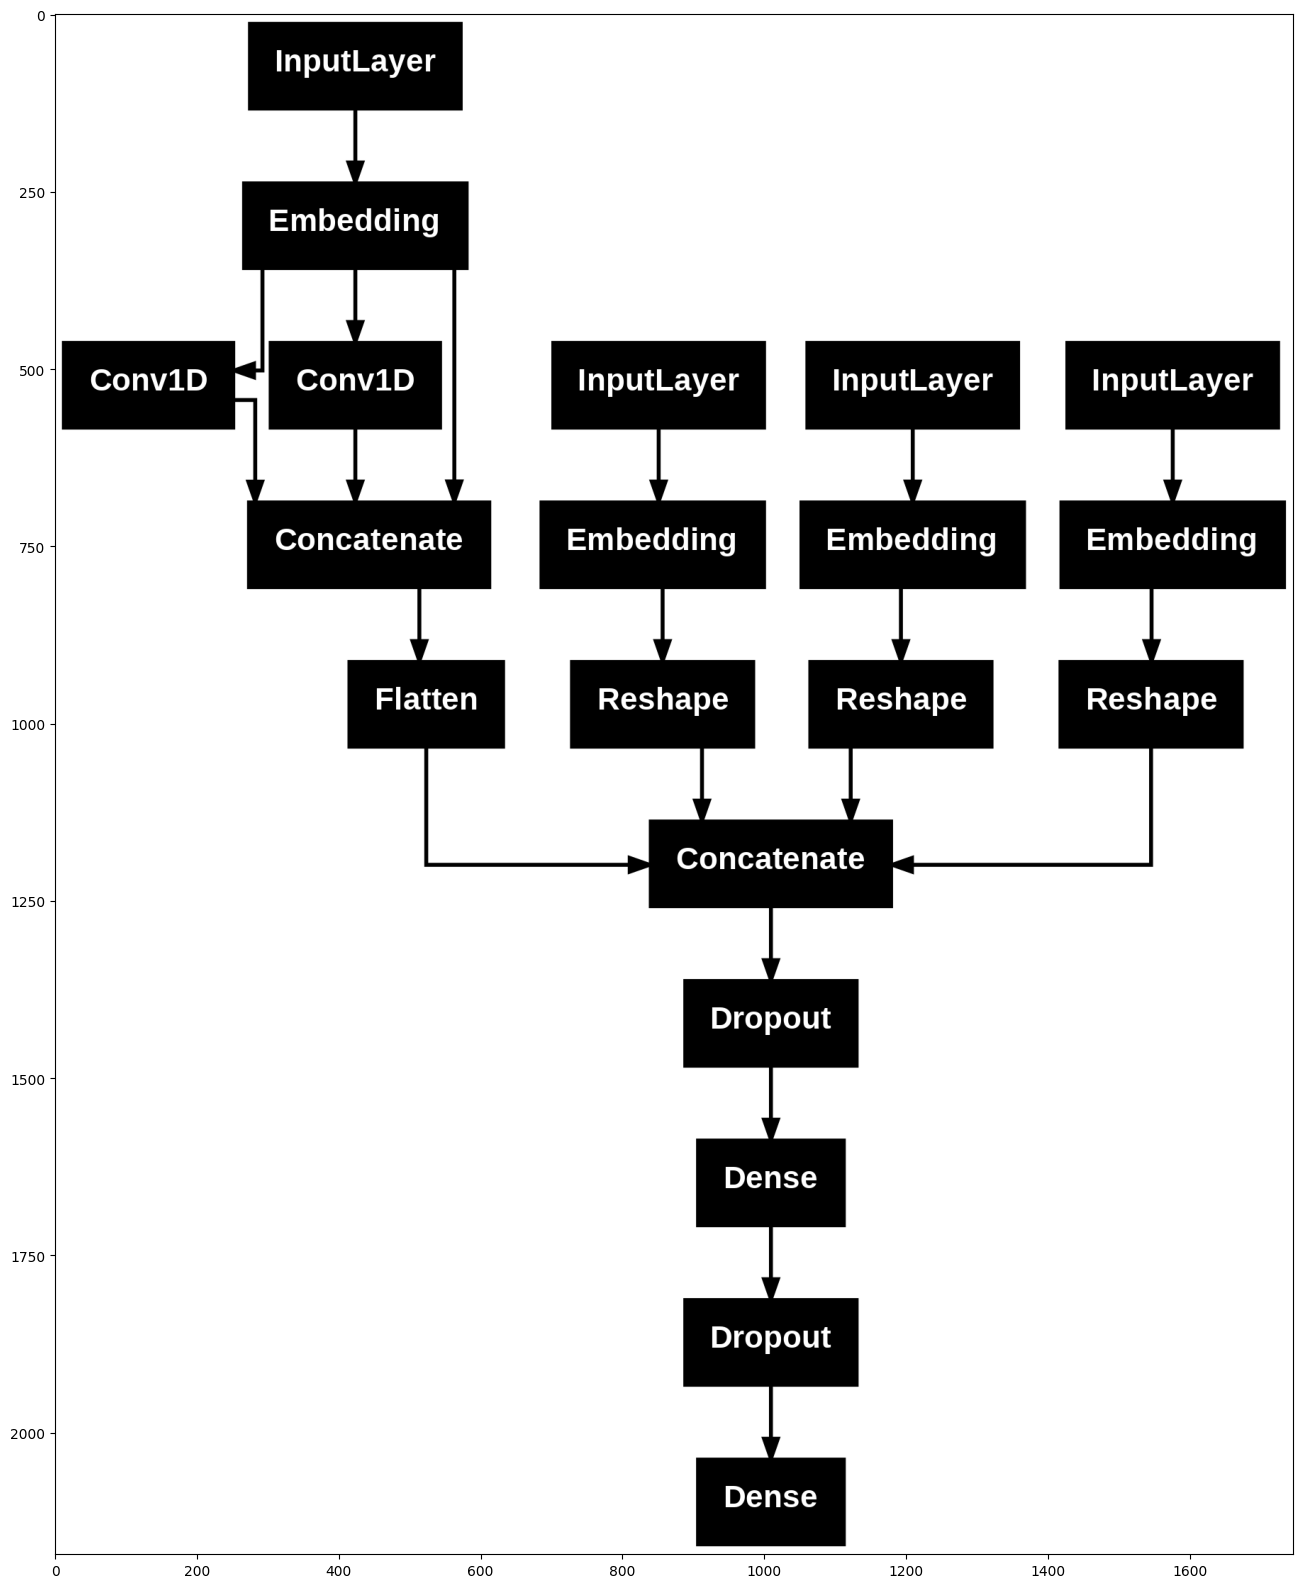

In [ ]:
model = create_model(sequence_length, n_char, unique_value)

# show model architecture
plot_model(model, to_file='model.png')
model_image = mpimg.imread('model.png')
plt.figure(figsize=(20, 20))
plt.imshow(model_image)
plt.show()

In [ ]:
### The model received 4 inputs, the first input came from URL that has been done tokenization and padding.
### Other inputs are subdomains, domains and suffix domains that have been encoded.
### URL input will pass through embedding layer and convolution layer while other input will pass embedding layer.
###Then the results from each input will be concatenated.

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ url_input (InputLayer)    │ (None, 235)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 235, 32)        │         10,560 │ url_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 235, 64)        │          6,208 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 235, 64)        │         10,304 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ subdomain_input           │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ domain_input (InputLayer) │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ domain_suffix_input       │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 235, 160)       │              0 │ embedding[0][0],       │
│                           │                        │                │ conv1d[0][0],          │
│                           │                        │                │ conv1d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 1, 4)           │        142,736 │ subdomain_input[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 1, 4)           │        516,280 │ domain_input[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 1, 4)           │          3,344 │ domain_suffix_input[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 37600)          │              0 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 4)              │              0 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 4)              │              0 │ embedding_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_2 (Reshape)       │ (None, 4)              │              0 │ embedding_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 37612)          │              0 │ flatten[0][0],         │
│ (Concatenate)             │                        │                │ reshape[0][0],         │
│                           │                        │                │ reshape_1[0][0],       │
│                           │                        │                │ reshape_2[0][0]        │
├──────────────────────

 Total params: 5,504,412 (21.00 MB)

 Trainable params: 5,504,412 (21.00 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
### Model Training

# create train data

#train_x = [train_seq.astype('float32'), train_data['subdomain'], train_data['domain'], train_data['domain_suffix']]

train_x = [
    train_seq.astype('float32'),
    tf.convert_to_tensor(np.asarray(train_data['subdomain'], dtype='int32').reshape(-1, 1)),
    tf.convert_to_tensor(np.asarray(train_data['domain'], dtype='int32').reshape(-1, 1)),
    tf.convert_to_tensor(np.asarray(train_data['domain_suffix'], dtype='int32').reshape(-1, 1))
]
train_y = train_data['type'].astype(int).values
train_y[:1]


array([0])

In [ ]:
early_stopping = [EarlyStopping(monitor='val_precision', patience=5, restore_best_weights=True, mode='max')]
history = model.fit(train_x, train_y, batch_size=64, epochs=25, verbose=1, validation_split=0.2, shuffle=True, callbacks=early_stopping)
model.save('model.h5')

Epoch 1/25
6512/6512 ━━━━━━━━━━━━━━━━━━━━ 56s 7ms/step - accuracy: 0.9160 - loss: 0.2421 - val_accuracy: 0.9666 - val_loss: 0.0986
Epoch 2/25


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning:

Early stopping conditioned on metric `val_precision` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss



6512/6512 ━━━━━━━━━━━━━━━━━━━━ 72s 7ms/step - accuracy: 0.9645 - loss: 0.1079 - val_accuracy: 0.9724 - val_loss: 0.0864
Epoch 3/25
6512/6512 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - accuracy: 0.9732 - loss: 0.0819 - val_accuracy: 0.9752 - val_loss: 0.0773
Epoch 4/25
6512/6512 ━━━━━━━━━━━━━━━━━━━━ 43s 6ms/step - accuracy: 0.9778 - loss: 0.0674 - val_accuracy: 0.9762 - val_loss: 0.0747
Epoch 5/25
6512/6512 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - accuracy: 0.9808 - loss: 0.0597 - val_accuracy: 0.9773 - val_loss: 0.0774
Epoch 6/25
6512/6512 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - accuracy: 0.9834 - loss: 0.0501 - val_accuracy: 0.9760 - val_loss: 0.0790
Epoch 7/25
6512/6512 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.9850 - loss: 0.0460 - val_accuracy: 0.9740 - val_loss: 0.0844
Epoch 8/25
6512/6512 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.9859 - loss: 0.0435 - val_accuracy: 0.9784 - val_loss: 0.0751
Epoch 9/25
6512/6512 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - accuracy: 0.9874 - loss: 0.0396 - val

In [ ]:
# val_x = [val_seq, val_data['subdomain'], val_data['domain'], val_data['domain_suffix']]
# val_y = val_data['type'].values

In [ ]:

# import tensorflow as tf
# import numpy as np

# val_x = [
#     val_seq,
#     tf.convert_to_tensor(np.asarray(val_data['subdomain'], dtype='int32').reshape(-1, 1)), # Convert to tensor
#     tf.convert_to_tensor(np.asarray(val_data['domain'], dtype='int32').reshape(-1, 1)),    # Convert to tensor
#     tf.convert_to_tensor(np.asarray(val_data['domain_suffix'], dtype='int32').reshape(-1, 1)) # Convert to tensor
# ]
# val_y = val_data['type'].values


In [ ]:
model_uploaded = tf.keras.models.load_model('model.h5')

In [ ]:
# val_pred = model.predict(val_x)

# print(f'Validation Data:\n{val_data.type.value_counts()}')


In [ ]:
# y_pred_classes = val_pred.argmax(axis=1)
# print("Unique values in y_true:", np.unique(val_y))
# print("Unique values in y_pred_classes:", np.unique(y_pred_classes))


In [ ]:
# print("Shape of y_true:", val_y.shape)
# print("Shape of y_pred_classes:", y_pred_classes.shape)


In [ ]:
# val_y = val_y.astype(int)
# y_pred_classes = y_pred_classes.astype(int)


In [ ]:
# from sklearn.metrics import precision_score, recall_score, f1_score


# # Precision, Recall, and F1 for each class
# precision = precision_score(val_y, y_pred_classes, average='weighted')
# recall = recall_score(val_y, y_pred_classes, average='weighted')
# f1 = f1_score(val_y, y_pred_classes, average='weighted')

# print("Precision:", precision)
# print("Recall:", recall)
# print("F1-score:", f1)

In [ ]:
# from sklearn.metrics import accuracy_score

# # Calculate accuracy
# accuracy = accuracy_score(val_y, y_pred_classes)

# # Print accuracy
# print("Accuracy Score:", accuracy)


In [ ]:
### Improving the model

### Add more filters
## use batch normalization
## add dropout to reduce overfitting
## add more dense layers
## Add L2 regularization to the dense layers to reduce overfitting.
## use a learning rate scheduler to adjust the learning rate
## add early stopping to prevent overfitting
##  Replace elu with relu to observe the performance.

In [ ]:
from tensorflow.keras import layers, models, regularizers, optimizers


def convolution_block2(x):
    conv_3_layer = layers.Conv1D(128, 3, padding='same', activation='relu')(x)  ### increase dense kayer
    conv_3_layer = layers.BatchNormalization()(conv_3_layer)

    conv_5_layer = layers.Conv1D(128, 5, padding='same', activation='relu')(x)
    conv_5_layer = layers.BatchNormalization()(conv_5_layer)   ### add batch normalization

    conv_7_layer = layers.Conv1D(128, 7, padding='same', activation='relu')(x)
    conv_7_layer = layers.BatchNormalization()(conv_7_layer)

    conv_layer = layers.concatenate([x, conv_3_layer, conv_5_layer, conv_7_layer])
    conv_layer = layers.Flatten()(conv_layer)
    return conv_layer

def embedding_block2(unique_value, size, name):
    input_layer = layers.Input(shape=(1,), name=name + '_input')
    embedding_layer = layers.Embedding(unique_value, size, input_length=1)(input_layer)
    embedding_layer = layers.Dropout(0.3)(embedding_layer)  ###adding dropout
    return input_layer, embedding_layer

def create_model2(sequence_length, n_char, unique_value):
    input_layer = []

    # sequence input layer
    sequence_input_layer = layers.Input(shape=(sequence_length,), name='url_input')
    input_layer.append(sequence_input_layer)

    # convolution block
    char_embedding = layers.Embedding(n_char + 1, 32, input_length=sequence_length)(sequence_input_layer)
    conv_layer = convolution_block2(char_embedding)

    # entity embedding
    entity_embedding = []
    for key, n in unique_value.items():
        size = min(50, (n + 1) // 2)   #### the size of the embedding layer based on the number of unique values n
        input_l, embedding_l = embedding_block2(n + 1, size, key)
        embedding_l = layers.Reshape(target_shape=(size,))(embedding_l)
        input_layer.append(input_l)
        entity_embedding.append(embedding_l)

    # concat all layers
    fc_layer = layers.concatenate([conv_layer, *entity_embedding])
    fc_layer = layers.Dropout(rate=0.5)(fc_layer)

    # dense layers
    fc_layer = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(fc_layer)  ### add more dense layer
    fc_layer = layers.Dropout(rate=0.3)(fc_layer)

    fc_layer = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(fc_layer) ### add L2
    fc_layer = layers.Dropout(rate=0.3)(fc_layer)

    # output layer
    output_layer = layers.Dense(4, activation='softmax')(fc_layer)

    model = models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping


lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model2 = create_model2(sequence_length, n_char, unique_value)
history_2 = model2.fit(train_x, train_y, batch_size=64, epochs=25, verbose=1, validation_split=0.2, shuffle=True, callbacks=[lr_scheduler, early_stopping])
model2.save('model2.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



Epoch 1/25
6512/6512 ━━━━━━━━━━━━━━━━━━━━ 138s 19ms/step - accuracy: 0.9060 - loss: 1.6266 - val_accuracy: 0.9532 - val_loss: 0.3635 - learning_rate: 1.0000e-04
Epoch 2/25
6512/6512 ━━━━━━━━━━━━━━━━━━━━ 113s 17ms/step - accuracy: 0.9493 - loss: 0.3657 - val_accuracy: 0.9619 - val_loss: 0.3138 - learning_rate: 1.0000e-04
Epoch 3/25
6512/6512 ━━━━━━━━━━━━━━━━━━━━ 108s 17ms/step - accuracy: 0.9559 - loss: 0.3320 - val_accuracy: 0.9630 - val_loss: 0.3105 - learning_rate: 1.0000e-04
Epoch 4/25
6512/6512 ━━━━━━━━━━━━━━━━━━━━ 142s 17ms/step - accuracy: 0.9590 - loss: 0.3106 - val_accuracy: 0.9667 - val_loss: 0.2807 - learning_rate: 1.0000e-04
Epoch 5/25
6512/6512 ━━━━━━━━━━━━━━━━━━━━ 142s 17ms/step - accuracy: 0.9617 - loss: 0.2997 - val_accuracy: 0.9697 - val_loss: 0.2511 - learning_rate: 1.0000e-04
Epoch 6/25
6512/6512 ━━━━━━━━━━━━━━━━━━━━ 141s 17ms/step - accuracy: 0.9641 - loss: 0.2811 - val_accuracy: 0.9684 - val_loss: 0.2513 - learning_rate: 1.0000e-04
Epoch 7/25
6512/6512 ━━━━━━━━━━━━━

In [ ]:
###  RNN MODEL


def LSTM_block(x):
    # conv_3_layer = layers.Conv1D(64, 3, padding='same', activation='elu')(x)

    # conv_5_layer = layers.Conv1D(64, 5, padding='same', activation='elu')(x)
    # conv_layer = layers.concatenate([x, conv_3_layer, conv_5_layer])

    # conv_layer = layers.Flatten()(conv_layer)

    return layers.LSTM(128)(x)


def embedding_block(unique_value, size, name):
    input_layer = layers.Input(shape=(1,), name=name + '_input')
    embedding_layer = layers.Embedding(unique_value, size, input_length=1)(input_layer)

    return input_layer, embedding_layer

def create_model(sequence_length, n_char, unique_value):
    input_layer = []

    # sequence input layer
    sequence_input_layer = layers.Input(shape=(sequence_length,), name='url_input')
    print(sequence_input_layer.shape)
    input_layer.append(sequence_input_layer)

    # convolution block
    char_embedding = layers.Embedding(n_char + 1, 32, input_length=sequence_length)(sequence_input_layer)
    print(char_embedding.shape)
    LTSM_layer = LSTM_block(char_embedding)
    print(LTSM_layer.shape)

    # entity embedding
    entity_embedding = []
    for key, n in unique_value.items():
        size = 4
        input_l, embedding_l = embedding_block(n + 1, size, key)
        embedding_l = layers.Reshape(target_shape=(size,))(embedding_l)
        input_layer.append(input_l)
        entity_embedding.append(embedding_l)

    # concat all layer
    fc_layer = layers.concatenate([LTSM_layer, *entity_embedding])
    print(fc_layer.shape)
    fc_layer = layers.Dropout(rate=0.5)(fc_layer)
    print(fc_layer.shape)

    # dense layer
    fc_layer = layers.Dense(128, activation='elu')(fc_layer)
    print(fc_layer.shape)
    fc_layer = layers.Dropout(rate=0.2)(fc_layer)
    print(fc_layer.shape)

    # output layer
    output_layer = layers.Dense(4, activation='softmax')(fc_layer)
    model = models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
!pip install pydot

(None, 235)
(None, 235, 32)
(None, 128)
(None, 140)
(None, 140)
(None, 128)
(None, 128)


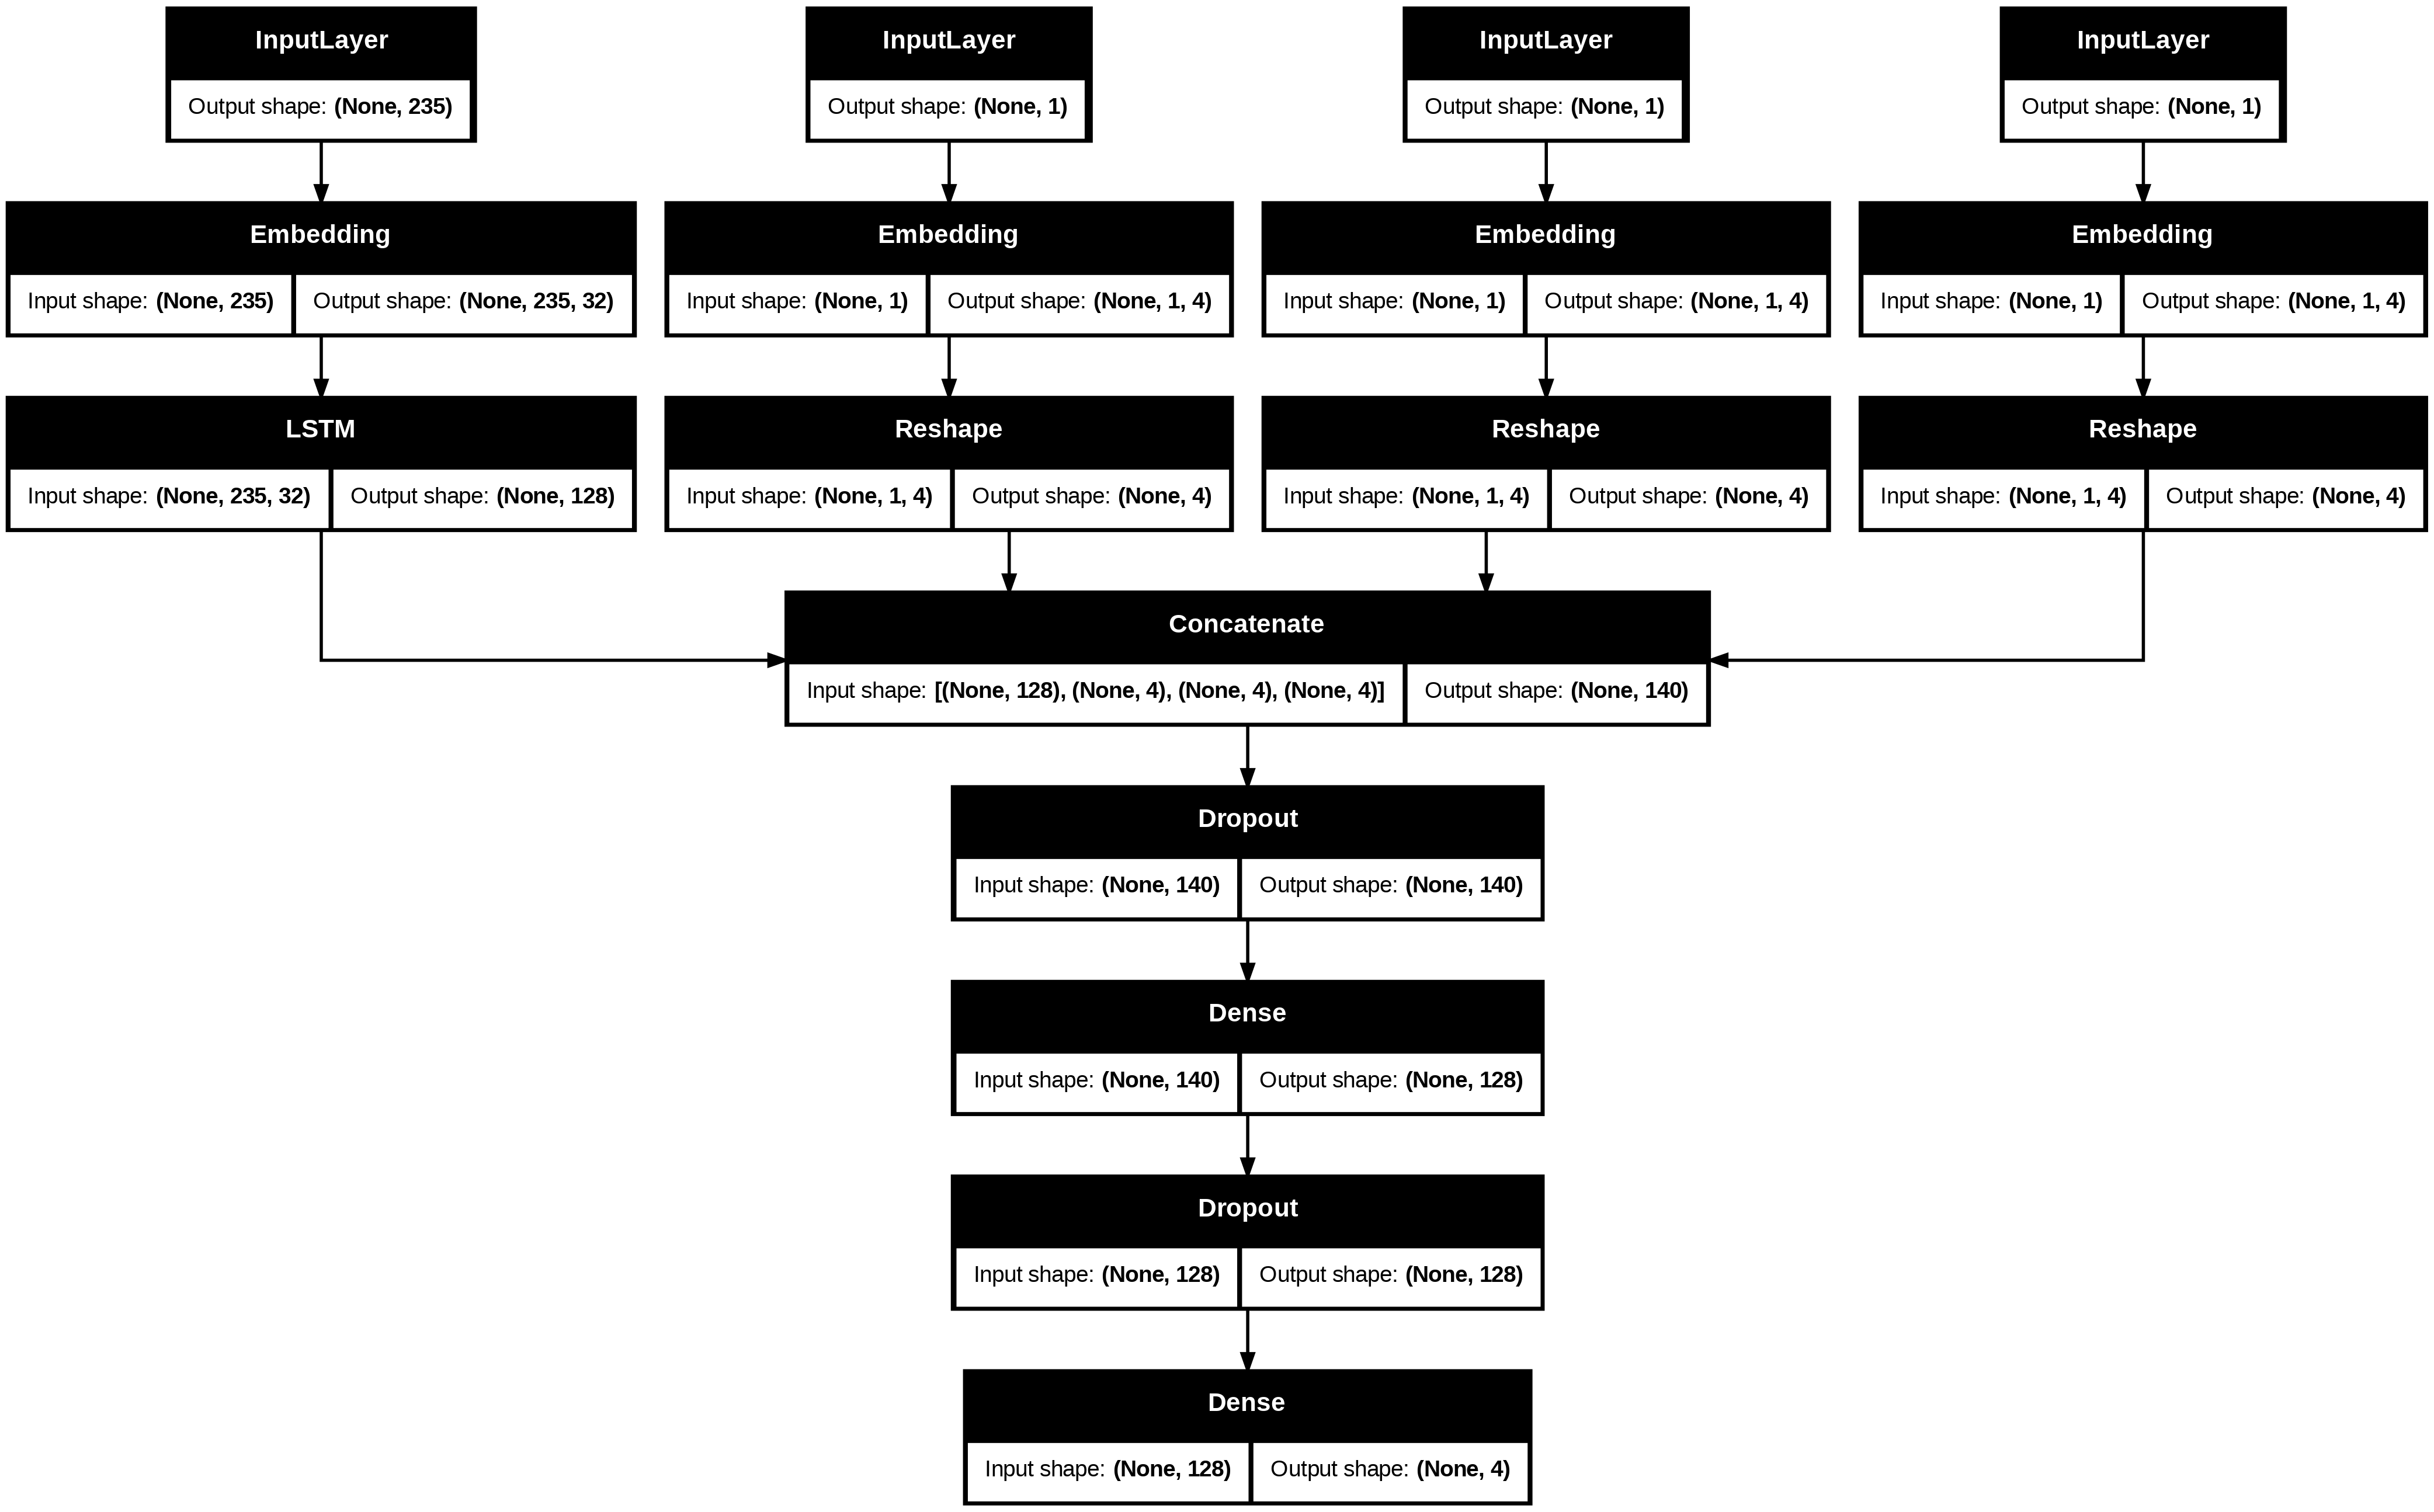

In [ ]:
rnn_model = create_model(sequence_length, n_char, unique_value)

plot_model(rnn_model,  show_shapes=True)

In [ ]:
rnn_model.summary()

In [ ]:
train_data['type'].astype(int).values

array([0, 1, 0, ..., 0, 1, 0])

In [ ]:
train_x = [
    train_seq.astype('float32'),
    tf.convert_to_tensor(np.asarray(train_data['subdomain'], dtype='int32').reshape(-1, 1)),
    tf.convert_to_tensor(np.asarray(train_data['domain'], dtype='int32').reshape(-1, 1)),
    tf.convert_to_tensor(np.asarray(train_data['domain_suffix'], dtype='int32').reshape(-1, 1))
]
train_y = train_data['type'].astype(int).values


early_stopping = [EarlyStopping(monitor='val_precision', patience=5, restore_best_weights=True, mode='max')]
history = rnn_model.fit(train_x, train_y, batch_size=64, epochs=25, verbose=1, validation_split=0.2, shuffle=True, callbacks=early_stopping)
rnn_model.save('rnn_model.h5')

Epoch 1/25
6512/6512 ━━━━━━━━━━━━━━━━━━━━ 126s 17ms/step - accuracy: 0.8015 - loss: 0.5672 - val_accuracy: 0.9148 - val_loss: 0.2356
Epoch 2/25
   9/6512 ━━━━━━━━━━━━━━━━━━━━ 1:27 13ms/step - accuracy: 0.8759 - loss: 0.3180

/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning:

Early stopping conditioned on metric `val_precision` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss



6512/6512 ━━━━━━━━━━━━━━━━━━━━ 106s 16ms/step - accuracy: 0.8959 - loss: 0.2946 - val_accuracy: 0.9217 - val_loss: 0.2082
Epoch 3/25
6512/6512 ━━━━━━━━━━━━━━━━━━━━ 143s 17ms/step - accuracy: 0.9217 - loss: 0.2325 - val_accuracy: 0.9227 - val_loss: 0.2101
Epoch 4/25
6512/6512 ━━━━━━━━━━━━━━━━━━━━ 138s 16ms/step - accuracy: 0.9354 - loss: 0.1995 - val_accuracy: 0.9269 - val_loss: 0.1939
Epoch 5/25
6512/6512 ━━━━━━━━━━━━━━━━━━━━ 144s 16ms/step - accuracy: 0.9496 - loss: 0.1444 - val_accuracy: 0.9574 - val_loss: 0.1284
Epoch 6/25
6512/6512 ━━━━━━━━━━━━━━━━━━━━ 140s 16ms/step - accuracy: 0.9628 - loss: 0.1086 - val_accuracy: 0.9665 - val_loss: 0.1106
Epoch 7/25
6512/6512 ━━━━━━━━━━━━━━━━━━━━ 103s 16ms/step - accuracy: 0.9705 - loss: 0.0878 - val_accuracy: 0.9699 - val_loss: 0.1004
Epoch 8/25
6512/6512 ━━━━━━━━━━━━━━━━━━━━ 141s 16ms/step - accuracy: 0.9773 - loss: 0.0713 - val_accuracy: 0.9721 - val_loss: 0.0924
Epoch 9/25
6512/6512 ━━━━━━━━━━━━━━━━━━━━ 143s 16ms/step - accuracy: 0.9808 - lo